In [38]:
from __future__ import division
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1234)
#!pip install imageio
import imageio

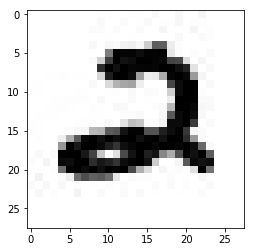

In [39]:
img_gray = imageio.imread('testSample/img_1.jpg')
plt.imshow(img_gray,cmap='Greys')

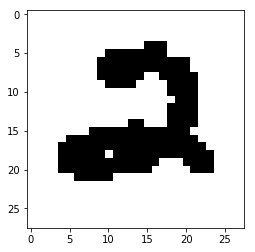

In [40]:
img_gray = imageio.imread('testSample/img_1.jpg')

#converting the picture to black and white
img_gray_arr = np.asarray(img_gray,int)
img_mean = np.mean(img_gray_arr)
img_arr = np.copy(img_gray_arr)
img_arr[img_gray_arr<img_mean] = -1
img_arr[img_gray_arr>= img_mean] = 1
plt.imshow(img_arr,cmap='Greys')

In [41]:
img_arr

array([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
         1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
         1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  

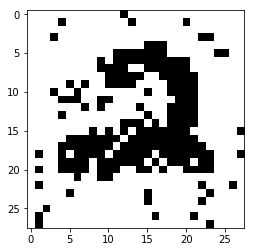

In [43]:
def make_noisy_image(lena_arr,per=0.1):
    total_pixels = lena_arr.shape[0]*lena_arr.shape[1]
    num_flips = int(per*total_pixels)
    px_to_flip = np.random.randint(low=0, high=total_pixels, size=num_flips)
    
    for i in px_to_flip:
        row_num = int(math.floor(i/lena_arr.shape[0]))
        col_num = i%lena_arr.shape[0]
        if lena_arr[row_num,col_num] == 1:
            lena_arr[row_num,col_num] =-1
        else:
            lena_arr[row_num, col_num]=1
    
noisy_img_arr = np.copy(img_arr) #important to deep copy the original array
make_noisy_image(noisy_img_arr)
plt.imshow(noisy_img_arr,cmap='Greys')

In [44]:
def percent_pixel_flipped(noisy_arr,denoised_arr):
    num_flipped = 0
    total_px = noisy_arr.shape[0]*noisy_arr.shape[1]
    for i in range(noisy_arr.shape[0]):
        for j in range(noisy_arr.shape[1]):
            if noisy_arr[i,j]!= denoised_arr[i,j]:
                num_flipped+=1
   
    percent_change = num_flipped*100./total_px
    return percent_change

print( percent_pixel_flipped(noisy_img_arr, img_arr))

8.673469387755102


In [45]:
def check_limit(value, limit):
    if value<0:
        value=limit-1
    if value==limit:
        value=0
    return value

def add_energy_contribution(visible_arr,hidden_arr, x_val,y_val, const_list):
    h_val = const_list[0]
    beta = const_list[1]
    eta = const_list[2]
    total_pixels = hidden_arr.shape[0]*hidden_arr.shape[1]
    energy = h_val*hidden_arr[x_val,y_val]
    energy += -eta*hidden_arr[x_val,y_val]*visible_arr[x_val,y_val]
    x_neighbor = [-1,1]
    y_neighbor = [-1,1]
    for i in x_neighbor:
        for j in y_neighbor:
            x_n = check_limit(x_val +i,hidden_arr.shape[0])
            y_n = check_limit(y_val +j, hidden_arr.shape[1])
            
            energy += -beta*hidden_arr[x_val,y_val]*hidden_arr[x_n,y_n]
    energy = energy/total_pixels
    return energy

def calculate_total_energy(visible_arr,hidden_arr,const_list):
    energy = 0.
    for i in range(visible_arr.shape[0]):
        for j in range(visible_arr.shape[1]):
            energy += add_energy_contribution(visible_arr,hidden_arr,i,j,const_list)
    return energy

#this list is [h, beta,eta]
const_list = [0,.1,.02]
hidden_image = np.copy(noisy_img_arr)
total_energy= calculate_total_energy(noisy_img_arr, hidden_image, const_list)

print (total_energy)


-0.24857142857142628


In [46]:
def icm_single_pixel(visible_arr, hidden_arr, px_x, px_y, total_energy, const_list):
    current_energy = add_energy_contribution(visible_arr, hidden_arr,px_x,px_y, const_list)
    other_energy = total_energy - current_energy
    #flip the pixel
    new_hidden_arr = np.copy(hidden_arr)
    if hidden_arr[px_x,px_y]==1:
        new_hidden_arr[px_x,px_y]=-1
    else:
        new_hidden_arr[px_x,px_y] = 1
    flipped_energy = add_energy_contribution(visible_arr, new_hidden_arr,px_x,px_y, const_list)
    #print current_energy, flipped_energy
    if flipped_energy < current_energy:
        should_flip = True
        total_energy = other_energy + flipped_energy
        hidden_arr = new_hidden_arr
        #print percent_pixel_flipped(hidden_arr, visible_arr)
    else:
        should_flip = False
    
    return (hidden_arr,should_flip,total_energy)
    #return (should_flip, hidden_arr, total_energy)

#main icm simulation
hidden_image = np.copy(noisy_img_arr)
energy_this_round = total_energy
print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))

for sim_round in range(5):
    for i in range(hidden_image.shape[0]):
        for j in range(hidden_image.shape[1]):
            hidden_image,should_flip,total_energy = icm_single_pixel(noisy_img_arr,hidden_image,i,j, total_energy,const_list)
            
        #print percent_pixel_flipped(hidden_image, lena_arr)
    if (total_energy - energy_this_round) == 0:
        print( "Algorithm converged")
        break
    energy_this_round = total_energy
    print ("Total Energy:",total_energy)
    print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))


% Pixels flipped: 8.673469387755102
Total Energy: -0.2934183673469368
% Pixels flipped: 4.719387755102041
Total Energy: -0.29433673469387567
% Pixels flipped: 4.719387755102041
Total Energy: -0.2947959183673451
% Pixels flipped: 4.591836734693878
Total Energy: -0.2948469387755084
% Pixels flipped: 4.464285714285714
Algorithm converged


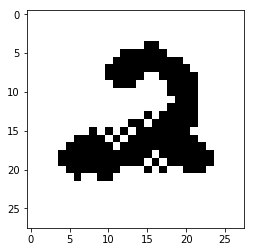

In [47]:
plt.imshow(hidden_image,cmap='Greys')